In [2]:
import boto3
import os
import pandas as pd
import glob
import matplotlib.pyplot as plt

from sagemaker import Session

# Initialize a SageMaker session
sagemaker_session = Session()



role = "arn:aws:iam::016114370410:role/tf-binding-sites"

prefix = "inference/output/FOXA1-22Rv1-AR-given-2024-07-29-12-49-54/"
local_dir = "/Users/wejarrard/projects/tf-binding/data/jsonl_output"


# Initialize the S3 client
s3 = boto3.client('s3')

# Specify your S3 bucket name
bucket_name = sagemaker_session.default_bucket()


# Function to download files from an S3 bucket
def download_from_s3(bucket_name, prefix, local_dir):
    if not os.path.exists(local_dir):
        os.makedirs(local_dir)

    # List objects within the specified prefix
    response = s3.list_objects_v2(Bucket=bucket_name, Prefix=prefix)

    # Iterate over each object
    for obj in response.get('Contents', []):
        key = obj['Key']
        # Skip if it's a folder
        if key.endswith('/'):
            continue
        local_path = os.path.join(local_dir, os.path.basename(key))
        
        # Download the file
        s3.download_file(bucket_name, key, local_path)
        print(f'Downloaded {key} to {local_path}')

# Bucket name extracted from the S3 URI
bucket_name = "tf-binding-sites"

# delete the files in local dir
for file in os.listdir(local_dir):
    os.remove(os.path.join(local_dir, file))
    

# Download the files
download_from_s3(bucket_name, prefix, "/Users/wejarrard/projects/tf-binding/data/jsonl_output")


# Path to the directory containing JSON files
json_dir = "/Users/wejarrard/projects/tf-binding/data/jsonl_output"

# Get a list of all JSON files in the directory
json_files = glob.glob(f"{json_dir}/*.jsonl.gz.out")

# Read each JSON file into a DataFrame and store in a list
dataframes = [pd.read_json(file) for file in json_files]

# Concatenate all DataFrames into a single DataFrame
df = pd.concat(dataframes, ignore_index=True)

df

Downloaded inference/output/FOXA1-22Rv1-AR-given-2024-07-29-12-49-54/dataset_1.jsonl.gz.out to /Users/wejarrard/projects/tf-binding/data/jsonl_output/dataset_1.jsonl.gz.out
Downloaded inference/output/FOXA1-22Rv1-AR-given-2024-07-29-12-49-54/dataset_10.jsonl.gz.out to /Users/wejarrard/projects/tf-binding/data/jsonl_output/dataset_10.jsonl.gz.out
Downloaded inference/output/FOXA1-22Rv1-AR-given-2024-07-29-12-49-54/dataset_11.jsonl.gz.out to /Users/wejarrard/projects/tf-binding/data/jsonl_output/dataset_11.jsonl.gz.out
Downloaded inference/output/FOXA1-22Rv1-AR-given-2024-07-29-12-49-54/dataset_12.jsonl.gz.out to /Users/wejarrard/projects/tf-binding/data/jsonl_output/dataset_12.jsonl.gz.out
Downloaded inference/output/FOXA1-22Rv1-AR-given-2024-07-29-12-49-54/dataset_13.jsonl.gz.out to /Users/wejarrard/projects/tf-binding/data/jsonl_output/dataset_13.jsonl.gz.out
Downloaded inference/output/FOXA1-22Rv1-AR-given-2024-07-29-12-49-54/dataset_2.jsonl.gz.out to /Users/wejarrard/projects/tf-bin

,chr_name,start,end,cell_line,targets,predicted,weights,probabilities,enhancer,promoter
0,chr1,940130,942508,22Rv1,0,0,1,0.000280,1,0
1,chr1,1364041,1364741,22Rv1,0,0,1,0.015646,1,0
2,chr1,1374373,1375946,22Rv1,0,1,1,0.981181,1,1
3,chr1,3359551,3360704,22Rv1,1,0,2,0.000185,1,0
4,chr1,3529281,3531798,22Rv1,1,1,6,0.972142,1,1
...,...,...,...,...,...,...,...,...,...,...
6777,chr4,134846499,134847270,22Rv1,1,1,7,0.997676,1,0
6778,chr4,138345870,138346615,22Rv1,1,1,6,0.613039,1,0
6779,chr4,138398331,138398843,22Rv1,1,1,8,0.973428,1,0
6780,chr4,138897529,138898891,22Rv1,1,1,6,0.995885,1,0


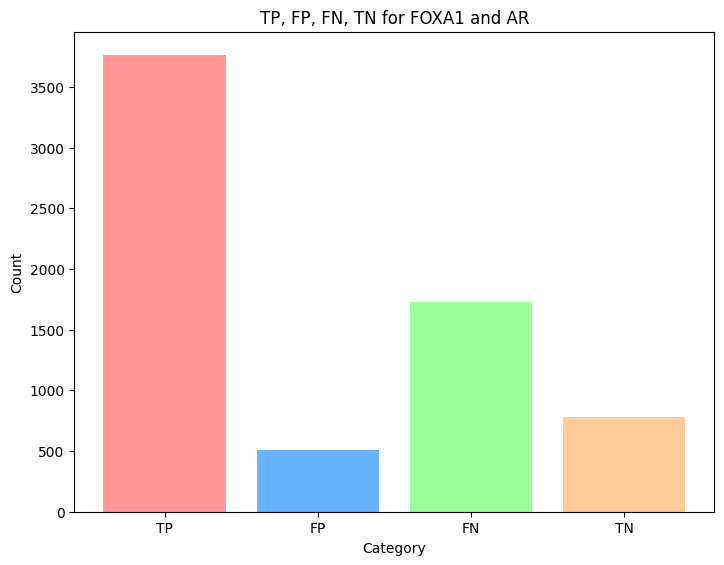

In [3]:
# get tp fp fn tn
tp = df[(df['targets'] == 1) & (df['predicted'] == 1)].shape[0]
fp = df[(df['targets'] == 0) & (df['predicted'] == 1)].shape[0]
fn = df[(df['targets'] == 1) & (df['predicted'] == 0)].shape[0]
tn = df[(df['targets'] == 0) & (df['predicted'] == 0)].shape[0]


# graph in bar chart
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
categories = ['TP', 'FP', 'FN', 'TN']
values = [tp, fp, fn, tn]
# add colors
colors = ['#ff9999','#66b3ff','#99ff99','#ffcc99']
ax.bar(categories, values, color=colors)
# add descriptive labels and title
plt.xlabel('Category')
plt.ylabel('Count')
plt.title('TP, FP, FN, TN for FOXA1 and AR')
plt.show()
